# Test notebook for the representation part

## Paper implementation:
### Metadata label generator
- SVM
- Confusion-matrix
- superclass division based on confusion matrix
### Intelligent reasoning
- Metadata creation (OvO OvR)
- RandomForest Classifier

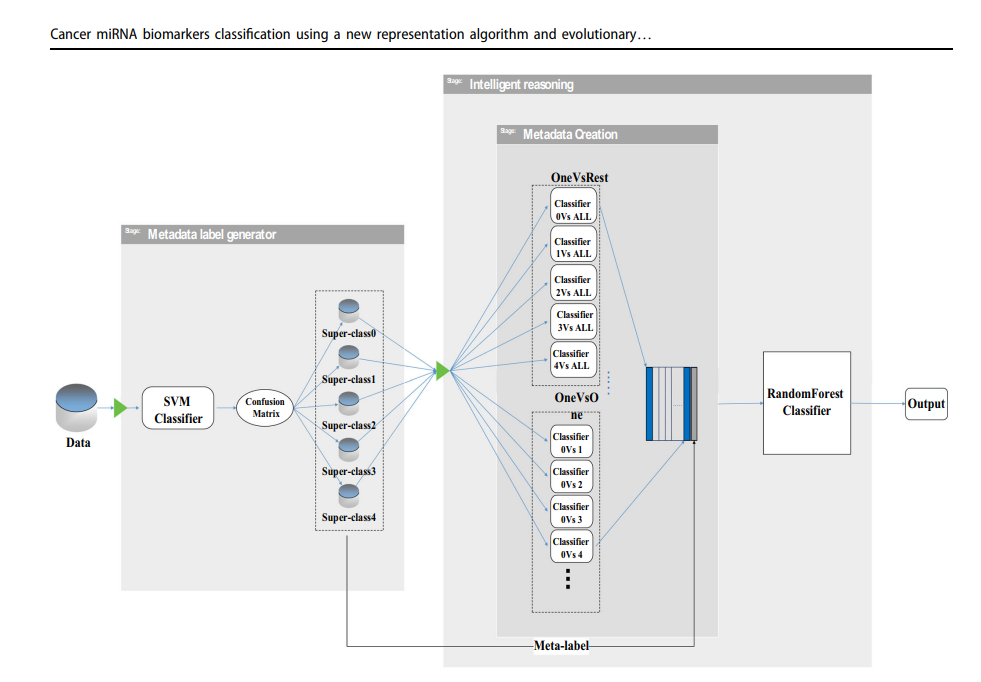

Fig. 4 Structure of meta-data classification

In [1]:
#TODO: Normalize data before every classification (Paper uses Z-Norm)
#TODO: after normalization, divide in two groups which are train and test
# The training process is divided in 
## 1. Representation learning (intelligent reasoning on the paper)
## 2. Feature selection 
## 3. GA-CNN Classifier 

#RESULT: Obtain n models [CNN] (where n is the number of super classes)

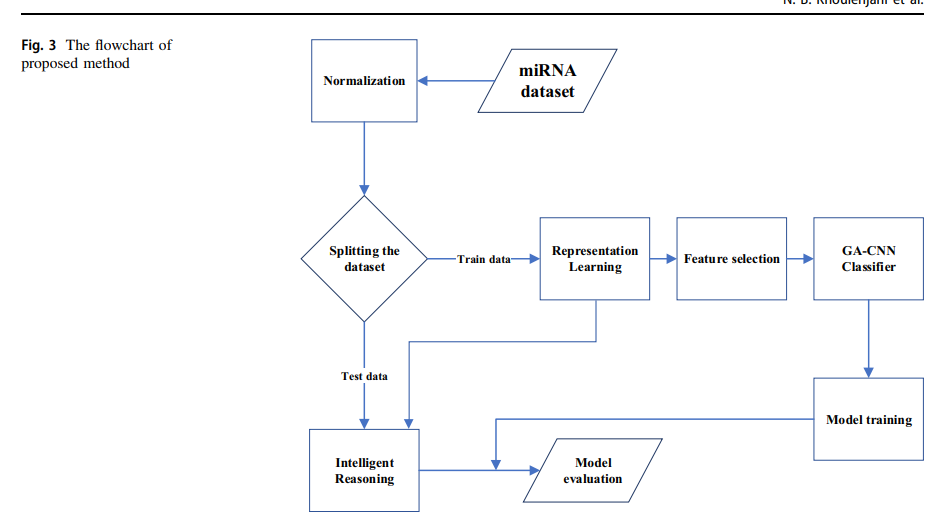

Metalabel generator:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.utils.utils import *
from sklearn import datasets, svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import scipy


#TODO: dataloader of data, normalization and split.

## Extract label and data 
label_path="data/MLinApp_course_data/tcga_mir_label.csv"
data_path="data/MLinApp_course_data/tcga_mir_rpm.csv"

miRna_label = extract_label(label_path)
miRna_data = np.genfromtxt(data_path, delimiter=',')[1:,0:-1]

In [2]:
## Labeling process: removing the duplicates
label_idx, dictionary = label_processing(miRna_label)
labels = np.unique(miRna_label, return_counts=True)

lab = []
for i in range(len(labels[0])):
  lab.append((labels[0][i], labels[1][i], dictionary[labels[0][i]]))

lab.sort(key= lambda x: x[1])

print(labels[0])

['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'COAD' 'DLBC' 'ESCA' 'GBM' 'HNSC'
 'KICH' 'KIRC' 'KIRP' 'LAML' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'OV' 'PAAD'
 'PCPG' 'PRAD' 'READ' 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM' 'UCEC'
 'UCS' 'UVM']


In [5]:
print(lab)

[('GBM', 5, 8), ('CHOL', 45, 4), ('DLBC', 47, 6), ('UCS', 57, 31), ('ACC', 80, 0), ('UVM', 80, 32), ('MESO', 87, 18), ('KICH', 91, 10), ('THYM', 126, 29), ('TGCT', 156, 27), ('READ', 165, 23), ('PAAD', 183, 20), ('PCPG', 187, 21), ('LAML', 188, 13), ('ESCA', 200, 7), ('SARC', 263, 24), ('CESC', 312, 3), ('KIRP', 326, 12), ('LIHC', 425, 15), ('BLCA', 437, 1), ('SKCM', 452, 25), ('COAD', 465, 5), ('STAD', 491, 26), ('OV', 499, 19), ('LUSC', 523, 17), ('LGG', 530, 14), ('PRAD', 551, 22), ('LUAD', 567, 16), ('HNSC', 569, 9), ('THCA', 573, 28), ('UCEC', 579, 30), ('KIRC', 616, 11), ('BRCA', 1207, 2)]


In [6]:
# Deleting all the data that came from TARGET-* labels
number_to_delete = abs(len(miRna_label) - miRna_data.shape[0])
miRna_data = miRna_data[number_to_delete:,:]

In [7]:
# Z-score normalization
miRna_data = scipy.stats.zscore(miRna_data, axis=1)
assert np.isnan(miRna_data).sum() == 0

In [8]:
# Splitting dataset in train and test using 60% train and 20% validation 20%evaluation
train_data, val_data, train_label, val_label = train_test_split(miRna_data, miRna_label, test_size=0.20, random_state=42)
#train_data, eva_data, train_label, eva_label = train_test_split(train_data, train_label, test_size=0.25, random_state=42)

In [9]:
n_classes = np.unique(train_label).size

print(n_classes)

33


In [10]:
print("Training set dimensions: {}".format(train_data.shape))
print("Validation set dimensions: {}".format(val_data.shape))
#print("Test set dimensions: {}".format(eva_data.shape))

print("\n")

print("Dimensions of a single sample: {}".format(train_data[0].shape))

Training set dimensions: (8865, 1881)
Validation set dimensions: (2217, 1881)


Dimensions of a single sample: (1881,)


In [11]:
from sklearn.model_selection import RandomizedSearchCV

#TODO: #3 SVM prior-classification and superclass identification confusion matrix based.
#classifier = svm.SVC(kernel="linear", C=0.01).fit(X_train, y_train)

random_grid_svm = {'kernel': ['rbf', 'poly', 'sigmoid'],
                   'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1],
                   'degree': [2,3,4,5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]}

In [14]:
search = RandomizedSearchCV(estimator=svm.SVC(),
                            param_distributions= random_grid_svm,
                            scoring='balanced_accuracy',
                            n_iter=10,
                            cv=3,
                            verbose=1,
                            random_state=42,
                            n_jobs=-1)

In [15]:
search.fit(train_data, train_label)
classifier = search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best params:

`{'kernel': 'poly',
 'gamma': 0.001,
 'degree': 4,
 'class_weight': 'balanced',
 'C': 20}`

In [11]:
model = svm.SVC(C=20, kernel='poly', gamma=0.001, degree=4, class_weight= 'balanced')



In [12]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import seaborn as sns
from typing import Tuple
from sklearn.metrics import confusion_matrix

def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba, model_

In [13]:
def lab2int(labels):
    lab = []
    for l in labels:
        lab.append(dictionary[l])
    return lab

In [14]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=lab2int(sorted_labels))
    
    plt.figure(figsize=(20,20))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

In [22]:
# Re-Training of the optimal model through cross validation, this is made to take the predictions.
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
actual_classes, predicted_classes, _ , classifier = cross_val_predict(model, kfold, train_data, np.array(lab2int(train_label)))

In [23]:
lab2int(labels[0])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

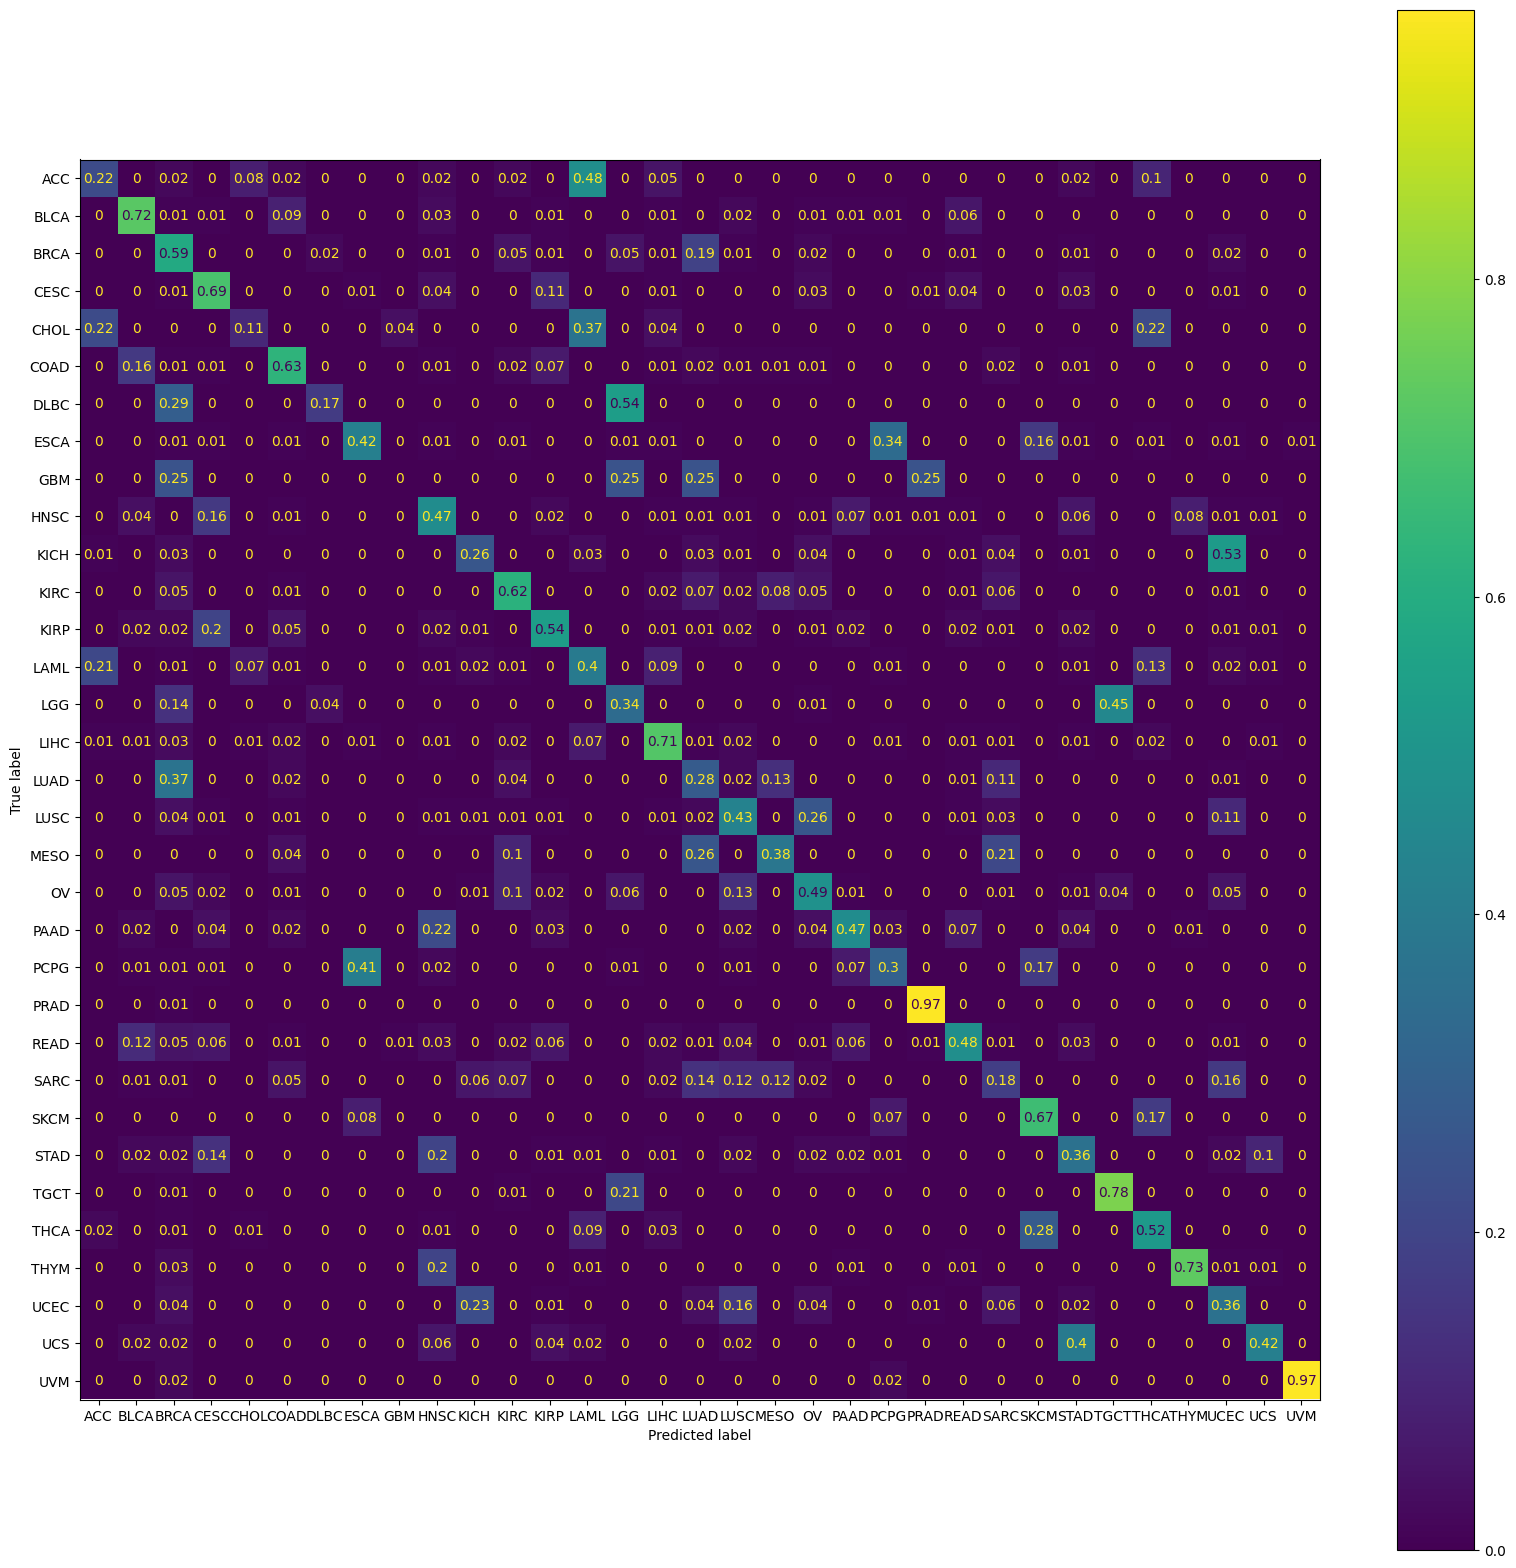

In [24]:
#Plotting confusion matrix. For the selection of superclass, use "cm".
from sklearn.metrics import confusion_matrix
import itertools
np.set_printoptions(precision=2)
cm = confusion_matrix(actual_classes, predicted_classes,normalize='true')
cmp = ConfusionMatrixDisplay(cm, display_labels=labels[0])
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        cm[i,j] = format(cm[i, j], '.2f')
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax)


In [ ]:
np.set_printoptions(precision=2)
test_predict = classifier.predict(val_data)
cm_t = confusion_matrix(lab2int(val_label), test_predict,normalize='true')
cmp = ConfusionMatrixDisplay(cm_t, display_labels=labels[0])
for i, j in itertools.product(range(cm_t.shape[0]), range(cm_t.shape[1])):
        cm_t[i,j] = format(cm_t[i, j], '.2f')
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax)


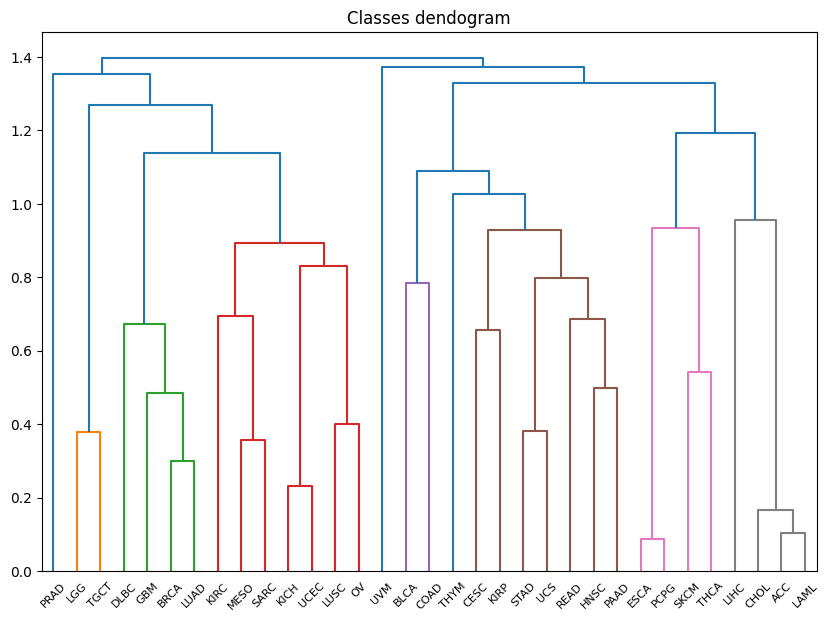

In [25]:
#We know that i is the class to predict and j is the predicted class. So cm[i][j] is the miss-classification ratio 
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Classes dendogram")

# Selecting Annual Income and Spending Scores by index

clusters = shc.linkage(cm, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters, labels=labels[0])
plt.show()

### Clustering Gerarchico (Ward + Euclidean distance) per superclass identification.

In [26]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
clustering_model.fit(cm)
clustering_model.labels_


d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([1, 4, 0, 4, 1, 4, 0, 1, 0, 4, 0, 0, 4, 1, 0, 1, 0, 0, 0, 0, 4, 1,
       3, 4, 0, 1, 4, 0, 1, 4, 0, 4, 2], dtype=int64)

In [27]:
#Labels = labels[0] (ordered)
#c_per_l = cluster per label
c_per_l = clustering_model.labels_
superclasses = {'0': [], '1': [], '2': [], '3': [], '4': []} #, '5': [], '6': [], '7': [] }
for i in range(len(labels[0])):
    superclasses[str(c_per_l[i])].append(labels[0][i])
for key in superclasses.keys():
    print(len(superclasses[key]))
    print(superclasses[key])




13
['BRCA', 'DLBC', 'GBM', 'KICH', 'KIRC', 'LGG', 'LUAD', 'LUSC', 'MESO', 'OV', 'SARC', 'TGCT', 'UCEC']
8
['ACC', 'CHOL', 'ESCA', 'LAML', 'LIHC', 'PCPG', 'SKCM', 'THCA']
1
['UVM']
1
['PRAD']
10
['BLCA', 'CESC', 'COAD', 'HNSC', 'KIRP', 'PAAD', 'READ', 'STAD', 'THYM', 'UCS']


### Other types of clustering for superclass identification without confusion matrix

In [15]:
#TODO: #4 Superclass division
## divide, ma con duplicati dentro le superclassi, da capire se è normale o meno
#train data -> miRna_data
#train label -> miRna_label

from sklearn.cluster import KMeans #divide in clusters
from sklearn.metrics import silhouette_score #calculate index of silhouette for the quality of the cluster

miRna_data_sc = train_data
miRna_label_sc = train_label
numberOfSuperclass = 5 #superclass 0...4
label_superclasses,data_superclasses=[],[]

#Kmeans
kmeans = KMeans(n_clusters=numberOfSuperclass, random_state=0)
cluster_labels = kmeans.fit_predict(miRna_data_sc)

#silhouette
silhouette_avg = silhouette_score(miRna_data_sc, cluster_labels)
#print(f"Silhouette Score: {silhouette_avg}")

#
data_superclasses = [[] for _ in range(numberOfSuperclass)]
label_superclasses = [[] for _ in range(numberOfSuperclass)]

#filling superclasses DUPLICATI
for i, cluster_label in enumerate(cluster_labels):
   data_superclasses[cluster_label].append(miRna_data_sc[i])
   label_superclasses[cluster_label].append(miRna_label_sc[i])

# TESTING TO REMOVE DUPLICATES - NOT YET WORKING
# for i, cluster_label in enumerate(cluster_labels):
#     data_superclasses[cluster_label].append(miRna_data_sc[i])
#     if miRna_label_sc[i] not in label_superclasses[cluster_label]:
#         label_superclasses[cluster_label].append(miRna_label_sc[i])

#results
for i in range(numberOfSuperclass):
    print("\nSuperclass: ",i)
    print(f"\nNumber of classes: {len(np.unique(label_superclasses[i]))}")
    for label in np.unique(label_superclasses[i]):
        elements=0
        for j in label_superclasses[i]:
            #print("val j: ",j)
            if j==label:
                elements=elements+1
                #print("qui dentro")
        print(f"\t{label}={elements}")

d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Superclass:  0

Number of classes: 20
	BLCA=4
	BRCA=72
	COAD=2
	DLBC=1
	ESCA=17
	KICH=1
	KIRC=290
	LGG=22
	LIHC=1
	LUAD=1
	LUSC=2
	OV=53
	PCPG=9
	SARC=2
	SKCM=5
	STAD=3
	THCA=8
	THYM=1
	UCEC=3
	UVM=16

Superclass:  1

Number of classes: 33
	ACC=46
	BLCA=206
	BRCA=625
	CESC=219
	CHOL=19
	COAD=277
	DLBC=21
	ESCA=89
	GBM=2
	HNSC=278
	KICH=66
	KIRC=103
	KIRP=237
	LAML=112
	LGG=111
	LIHC=144
	LUAD=233
	LUSC=192
	MESO=19
	OV=267
	PAAD=112
	PCPG=95
	PRAD=10
	READ=97
	SARC=72
	SKCM=181
	STAD=236
	TGCT=2
	THCA=241
	THYM=3
	UCEC=309
	UCS=47
	UVM=13

Superclass:  2

Number of classes: 32
	ACC=17
	BLCA=24
	BRCA=263
	CESC=3
	CHOL=8
	COAD=78
	DLBC=13
	ESCA=50
	GBM=1
	HNSC=54
	KICH=2
	KIRC=106
	KIRP=1
	LAML=38
	LGG=24
	LIHC=135
	LUAD=217
	LUSC=183
	MESO=48
	OV=36
	PAAD=3
	PCPG=38
	PRAD=17
	READ=6
	SARC=115
	SKCM=127
	STAD=118
	THCA=179
	THYM=95
	UCEC=100
	UCS=4
	UVM=34

Superclass:  3

Number of classes: 27
	BLCA=107
	BRCA=15
	CESC=26
	COAD=26
	ESCA=5
	HNSC=127
	KICH=5
	KIRC=6
	KIRP=18
	LAML=1
	LGG=

In [ ]:
#TODO: 4 --- kmeans + no duplicates between superclasses
from sklearn.cluster import KMeans
import numpy as np
from collections import defaultdict

miRna_data_sc = train_data
miRna_label_sc = train_label
numberOfSuperclass = 5  # Superclass 0...4
label_superclasses, data_superclasses = [], []

#kmeans
kmeans = KMeans(n_clusters=numberOfSuperclass, random_state=0)
cluster_labels = kmeans.fit_predict(miRna_data_sc)

data_superclasses = [[] for _ in range(numberOfSuperclass)]
label_superclasses = [[] for _ in range(numberOfSuperclass)]

#to track the assigned labels and their count
assigned_labels = {i: defaultdict(int) for i in range(numberOfSuperclass)}

#filling superclasses and assigned labels -> actually counting
for i, cluster_label in enumerate(cluster_labels):
    data_point = miRna_data_sc[i]
    label = miRna_label_sc[i]

    #check if the label is in the current superclass
    if label in assigned_labels[cluster_label]:
        assigned_labels[cluster_label][label] += 1
    else:
        assigned_labels[cluster_label][label] = 1

    #check if its in any else
    assigned_to_other_superclass = False
    for other_superclass in range(numberOfSuperclass):
        if other_superclass != cluster_label and label in assigned_labels[other_superclass]:
            assigned_to_other_superclass = True
            break

    if not assigned_to_other_superclass:
        #no superclasses
        data_superclasses[cluster_label].append(data_point)
        label_superclasses[cluster_label].append(label)

#result
for i in range(numberOfSuperclass):
    print("\nSuperclass: ", i)
    print(f"\nNumber of classes: {len(np.unique(label_superclasses[i]))}")
    
    #keeping only the max
    max_label = max(assigned_labels[i], key=assigned_labels[i].get)
    
    for label in np.unique(label_superclasses[i]):
        elements = assigned_labels[i][label]
        print(f"\t{label}={elements}")


In [ ]:
#TODO: #4 tsne
from sklearn.manifold import TSNE
import numpy as np
from collections import defaultdict

miRna_data_sc = train_data
miRna_label_sc = train_label
numberOfSuperclass = 2  # Superclass 0...4 #se metto 5 va in errore perché il tsne è bidim
label_superclasses, data_superclasses = [], []

#t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=0)
tsne_result = tsne.fit_transform(miRna_data_sc)

# tsne to divide -> stackoverflow
x_min, x_max = np.min(tsne_result, 0), np.max(tsne_result, 0)
X_norm = (tsne_result - x_min) / (x_max - x_min)
superclass_assignment = np.argmin(X_norm, axis=1)

data_superclasses = [[] for _ in range(numberOfSuperclass)]
label_superclasses = [[] for _ in range(numberOfSuperclass)]

#counting assigned labels 
assigned_labels = {i: defaultdict(int) for i in range(numberOfSuperclass)}

#filling superclasses
for i, cluster_label in enumerate(superclass_assignment):
    data_point = miRna_data_sc[i]
    label = miRna_label_sc[i]

    #removing duplicates if any in the superclass, and counting the number of elements
    if label in assigned_labels[cluster_label]:
        assigned_labels[cluster_label][label] += 1
    else:
        assigned_labels[cluster_label][label] = 1

    #check if assigned to any other superclass
    assigned_to_other_superclass = False
    for other_superclass in range(numberOfSuperclass):
        if other_superclass != cluster_label and label in assigned_labels[other_superclass]:
            assigned_to_other_superclass = True
            break

    if not assigned_to_other_superclass:
        #not assigned in any
        data_superclasses[cluster_label].append(data_point)
        label_superclasses[cluster_label].append(label)

#result
for i in range(numberOfSuperclass):
    print("\nSuperclass: ", i)
    print(f"\nNumero di classi: {len(np.unique(label_superclasses[i]))}")

    #removing outliers 
    max_label = max(assigned_labels[i], key=assigned_labels[i].get)

    for label in np.unique(label_superclasses[i]):
        elements = assigned_labels[i][label]
        print(f"\t{label}={elements}")


 PCA + kmeans (two steps)

getting the best number of components


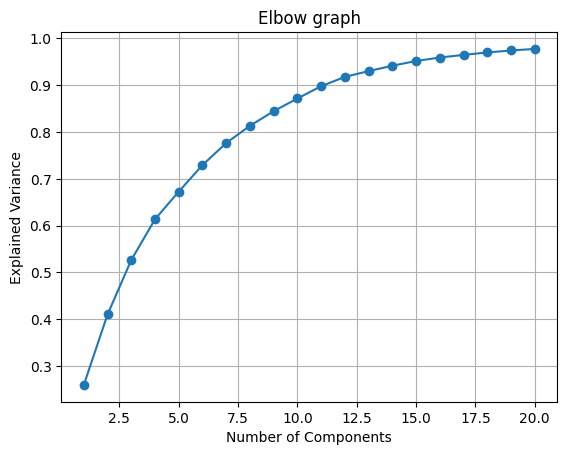

In [26]:
#TODO: #4 -> PCA + Kmeans
#Part 1
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
print("getting the best number of components")
miRna_data_sc = train_data
miRna_label_sc = train_label
# Fit PCA with a range of components
n_components_range = range(1, 21)  
explained_variances = []

for n in n_components_range:
    pca = PCA(n_components=n)
    pca.fit(miRna_data_sc)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

# Plot the explained variances
plt.plot(n_components_range, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Elbow graph')
plt.grid()
plt.show()


In [25]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from collections import defaultdict

miRna_data_sc = train_data
miRna_label_sc = train_label
numberOfSuperclass = 5  # Superclass 0...4
label_superclasses, data_superclasses = [], []

# PCA
n_components = 13  #10-15
pca = PCA(n_components=n_components)
miRna_data_pca = pca.fit_transform(miRna_data_sc)

# K-Means
kmeans = KMeans(n_clusters=numberOfSuperclass, random_state=0)
cluster_labels = kmeans.fit_predict(miRna_data_pca)

data_superclasses = [[] for _ in range(numberOfSuperclass)]
label_superclasses = [[] for _ in range(numberOfSuperclass)]

# To track the assigned labels and their count
assigned_labels = {i: defaultdict(int) for i in range(numberOfSuperclass)}

# Filling superclasses and assigned labels -> actually counting
for i, cluster_label in enumerate(cluster_labels):
    data_point = miRna_data_sc[i]
    label = miRna_label_sc[i]

    # Check if the label is in the current superclass
    if label in assigned_labels[cluster_label]:
        assigned_labels[cluster_label][label] += 1
    else:
        assigned_labels[cluster_label][label] = 1

    # Check if it's in any else
    assigned_to_other_superclass = False
    for other_superclass in range(numberOfSuperclass):
        if other_superclass != cluster_label and label in assigned_labels[other_superclass]:
            assigned_to_other_superclass = True
            break

    if not assigned_to_other_superclass:
        # No superclasses
        data_superclasses[cluster_label].append(data_point)
        label_superclasses[cluster_label].append(label)
        
print("\nNumber of components: ",n_components)
# Result
for i in range(numberOfSuperclass):
    print("\nSuperclass: ", i)
    print(f"\nNumber of classes: {len(np.unique(label_superclasses[i]))}")

    # Keeping only the max
    max_label = max(assigned_labels[i], key=assigned_labels[i].get)

    for label in np.unique(label_superclasses[i]):
        elements = assigned_labels[i][label]
        print(f"\t{label}={elements}")



Number of components:  13

Superclass:  0

Number of classes: 10
	ACC=17
	BRCA=260
	CHOL=8
	DLBC=13
	KIRC=106
	LIHC=135
	SARC=115
	SKCM=126
	THCA=178
	THYM=95

Superclass:  1

Number of classes: 18
	BLCA=204
	CESC=219
	COAD=276
	ESCA=89
	GBM=2
	HNSC=278
	KICH=66
	KIRP=237
	LAML=112
	LUAD=233
	LUSC=192
	MESO=19
	OV=268
	PAAD=112
	PCPG=95
	READ=97
	STAD=238
	UCS=47

Superclass:  2

Number of classes: 1
	PRAD=414

Superclass:  3

Number of classes: 2
	UCEC=4
	UVM=17

Superclass:  4

Number of classes: 2
	LGG=268
	TGCT=115


c:\Users\shado\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Metadata generation

### Metada generation

In [16]:
#TODO: #5 Metadata creation (OvO - One v One + OvR - One v Rest) + Random Forest classification
#In the paper they use GradientBoosting for metadata creation
from sklearn.ensemble import GradientBoostingClassifier as gb
from sklearn.multiclass import OneVsRestClassifier as ovr, OneVsOneClassifier as ovo 
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import seaborn as sns
from typing import Tuple
import pickle as pkl
from sklearn.metrics import confusion_matrix

In [79]:
#CROSS VALIDATION FOR METADATA CREATION, WE USE CV TO CREATE THE METADATA ON THE TRAINING SET WITHOUT BIASING IT.
#1. OVO AND OVR ARE TRAINED
#2. THE MODELS OF OVO AND OVR MAKES PREDICTIONS ON THE DATA
#3. THE PREDICTIONS ARE TAKEN AS METADATA
#4. ALL THE DATA ARE STACKED TOGETHER AS A METADATA MATRIX.

def meta_data_creation_train(ovo, ovr, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    ovo_ = cp.deepcopy(ovo)
    ovr_ = cp.deepcopy(ovr)
    
    actual_classes = np.empty([0], dtype=int)
    scores_ovo = []
    scores_ovr = []
    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)
        #train
        ovo_.fit(train_X, train_y)
        ovr_.fit(train_X, train_y)
        
        models_ovo = list(ovo_.estimators_)
        models_ovr = list(ovr_.estimators_)
      
        for mod in models_ovo:
            scores_ovo.append(mod.predict(test_X))
        for mod in models_ovr:
            scores_ovr.append(mod.predict(test_X))
    
    meta_data = np.hstack(np.array(scores_ovo).T, np.array(scores_ovr).T)

    return meta_data, actual_classes, ovo_, ovr_

def save_metadata(metadata, metalabel):
    print("Saving metadata...")
    with open("data/metadata/metadata_train.pkl", "wb") as f:
        pkl.dump(metadata, f)

    with open("data/metadata/metalabel_train.pkl", "wb") as f:
        pkl.dump(metalabel, f)

    print("Complete!")

def load_metadata():
    metadata = []
    metalabel = []
    with open("data/metadata/metadata_train.pkl", "rb") as f:
        metadata = pkl.load(f)

    with open("data/metadata/metalabel_train.pkl", "rb") as f:
        metalabel = pkl.load(f)

    return metadata, metalabel


In [ ]:
#inizializing models

ovo_model = ovo(gb(), n_jobs=-1) #One vs One with GradientBoostingClassifier
ovr_model = ovr(gb(), n_jobs=-1) #One vs Rest with GradientBoostingClassifier
rf_model = RandomForestClassifier()

In [34]:
#Replacing label with superclass labels.

train_super_label = train_label
for k,v in superclasses.items():
    for a in v:
        train_super_label = list(map(lambda x: x.replace(a, k), train_super_label))
train_super_label = [int(x) for x in train_super_label]

In [ ]:
#meta_data creation of training set through cross_validation.
#TODO: Dobbiamo stackare la metalabel alla fine?
#TODO: TRAINARE E GENERARE META-LABEL 
import pickle as pkl

meta_data, meta_label, t_ovo, t_ovr = meta_data_creation_train(ovo_model, ovr_model, 5, train_data, train_super_label)

save_metadata(meta_data, meta_label)

In [ ]:
print("Training metadata dimensions: {}".format(meta_data.shape))
#print("Test set dimensions: {}".format(eva_data.shape))
print("\n")

print("Dimensions of a single sample: {}".format(meta_data[0].shape))